# Preprocessing Steps
1. Define bad and dead channels
    - note: manual inspection first? The authors seemed to go in loops and find the bad channels after all the preprocessing are done (artifacts found in autorejects and IC rejections)
For (each participant):
2. Downsample (1000Hz -> 250Hz)
    - note: original data has 260Hz low pass filter
3. Bandpass Filter (0.1, 30Hz)
4. Remove 50Hz. Original paper: notch Filter (50Hz (48, 52, 1))
5. Remove bad channels (if more than 4: remove participant)
6. Rerefenrence (mastoid)
7. Isolate some data to run ICA (epoching? starting with each new cue)
8. Remove bad trials (find artifacts)
9. Run ICA
10. Perform auto-rejection per ICLabel
11. Interpolation

>NOTE: two-pass preprocessing: go through the preprocessing steps once and then see if there is still bad channels remaining. if so, mark them and start over again.

**NOTES**
- nonLearners = [3 5 9 12 20 24 25 29 30 32 33]

In [16]:
import mne
from mne_bids import (BIDSPath,read_raw_bids)
from meegkit.dss import dss_line
import sys
sys.path.insert(0,'.')
import os
import ccs_eeg_utils
from matplotlib import pyplot as plt
import numpy as np
from find_trial_artifact import find_artifacts

# Load the dataset

In [17]:
bids_root = "C:\\Users\\Zheng\\Desktop\\fourth semester\\EEG\\reward_dataset\\reward_dataset\\reward_dataset"
subject_id = '27'

bids_path = BIDSPath(subject=subject_id, task='casinos',
                     datatype='eeg', suffix='eeg',
                     root=bids_root)

# read the file
raw = read_raw_bids(bids_path)
# fix the annotations readin
ccs_eeg_utils.read_annotations_core(bids_path,raw)

Extracting parameters from C:\Users\Zheng\Desktop\fourth semester\EEG\reward_dataset\reward_dataset\reward_dataset\sub-27\eeg\sub-27_task-casinos_eeg.vhdr...
Setting channel info structure...
Reading events from C:\Users\Zheng\Desktop\fourth semester\EEG\reward_dataset\reward_dataset\reward_dataset\sub-27\eeg\sub-27_task-casinos_events.tsv.
The event "Stimulus" refers to multiple event values.Creating hierarchical event names.
    Renaming event: Stimulus -> Stimulus/S  1
    Renaming event: Stimulus -> Stimulus/S  2
    Renaming event: Stimulus -> Stimulus/S  3
    Renaming event: Stimulus -> Stimulus/S  4
    Renaming event: Stimulus -> Stimulus/S  6
    Renaming event: Stimulus -> Stimulus/S  1
    Renaming event: Stimulus -> Stimulus/S  2
    Renaming event: Stimulus -> Stimulus/S  3
    Renaming event: Stimulus -> Stimulus/S  5
    Renaming event: Stimulus -> Stimulus/S  6
    Renaming event: Stimulus -> Stimulus/S  1
    Renaming event: Stimulus -> Stimulus/S  2
    Renaming even

C:\Users\Zheng\AppData\Local\Temp\ipykernel_50672\69566942.py:9: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 27
date: 18-Mar-2022 13:55:40
handedness: R
order: 50-50 mixed 80-20
stimuli: a lemon an orange
  raw = read_raw_bids(bids_path)


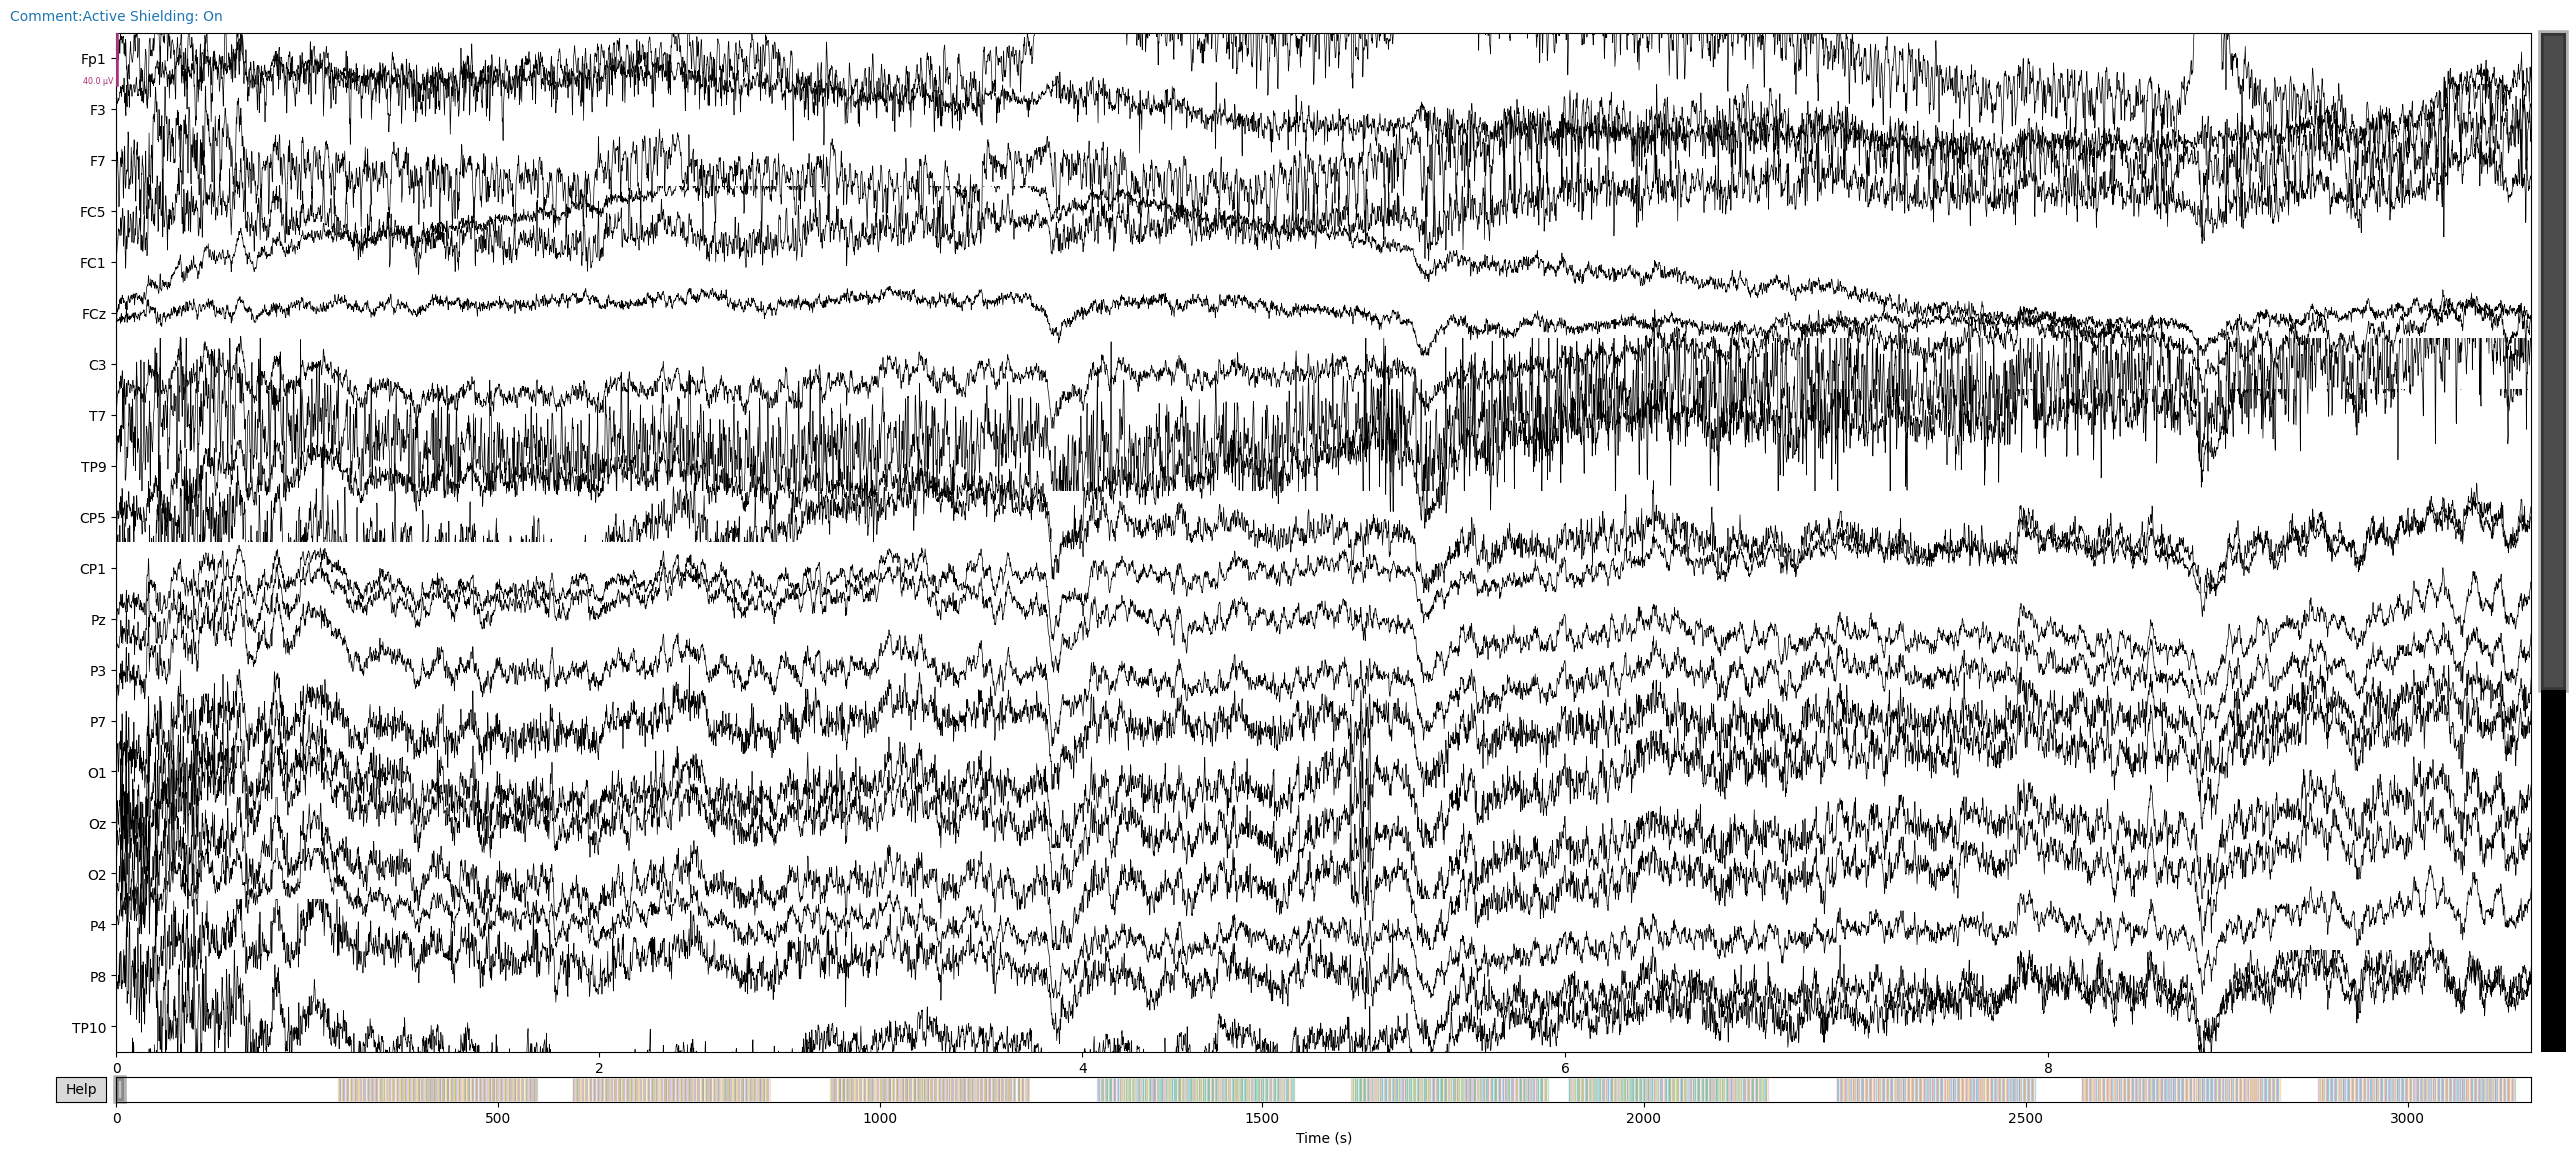

Reading 0 ... 3161619  =      0.000 ...  3161.619 secs...


<RawBrainVision | sub-27_task-casinos_eeg.eeg, 31 x 3161620 (3161.6 s), ~747.8 MiB, data loaded>

In [18]:
### Examine the raw data, manually mark the bad channels?
raw.plot()
#raw.get_data()  # extract data as numpy
raw.load_data()  # load to memory

In [19]:
from mne.io import RawArray

# add reference channel for site 2
info_fz = mne.create_info(
    ch_names=['Fz'],
    sfreq=raw.info['sfreq'],
    ch_types=['eeg']
)

# create zero-filled data array for Fz
n_times = raw.n_times
zeros_data = np.zeros((1,n_times)) # (num_channels, num_times)
raw_fz = RawArray(zeros_data, info_fz)

# merge with original data
raw.add_channels([raw_fz], force_update_info=True)
print("Fz channel successfully added to the continuous data.")


Creating RawArray with float64 data, n_channels=1, n_times=3161620
    Range : 0 ... 3161619 =      0.000 ...  3161.619 secs
Ready.
Fz channel successfully added to the continuous data.


>Q: how is refenrence channel used in the later analysis?

# Set the Montage

In [20]:
#NOTE: download .locs file from author's Github, put it under root_of_dataset/code/..
locs_filename = 'site2channellocations.locs'
locs_path = os.path.join(bids_root, 'code', locs_filename)      
custom_montage = mne.channels.read_custom_montage(locs_path)
raw.set_montage(custom_montage, match_case=False)

<RawBrainVision | sub-27_task-casinos_eeg.eeg, 32 x 3161620 (3161.6 s), ~771.9 MiB, data loaded>

# Downsample

In [21]:
new_sfreq = 250
eeg_down = raw.copy().resample(new_sfreq, npad='auto')
print(f"Original Sampling Rate: {raw.info['sfreq']} Hz")
print(f"New Sampling Rate: {eeg_down.info['sfreq']} Hz")

Original Sampling Rate: 1000.0 Hz
New Sampling Rate: 250.0 Hz


# Bandpass

In [22]:
f_low = 0.1
f_high = 30

# manipulate the cutoff frequencies if needed
eeg_band = eeg_down.copy().filter(l_freq=f_low, h_freq=f_high)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 s)



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


C:\Users\Zheng\AppData\Local\Temp\ipykernel_50672\3304367058.py:1: UserWarning: Zero value in spectrum for channel Fz
  eeg_band.copy().plot_psd(fmax=60) # before notch filter check the spectrum, no obvious 50hz noise
C:\Users\Zheng\AppData\Local\Temp\ipykernel_50672\3304367058.py:1: UserWarning: Infinite value in PSD for channel Fz.
These channels might be dead.
  eeg_band.copy().plot_psd(fmax=60) # before notch filter check the spectrum, no obvious 50hz noise
d:\anaconda\envs\EEG\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


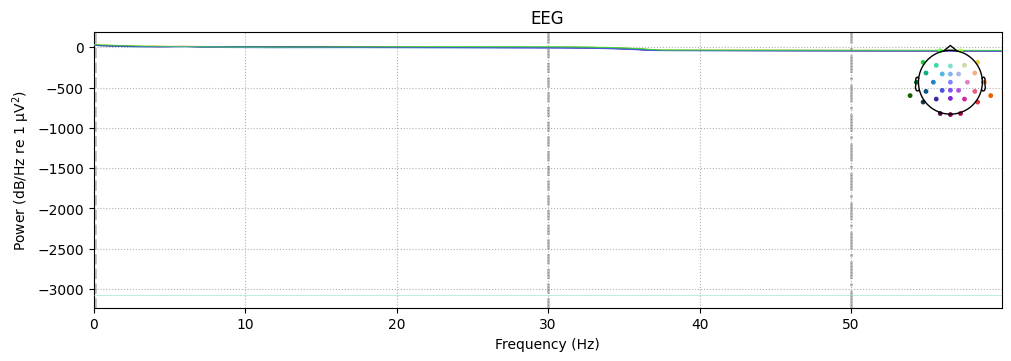

In [23]:
eeg_band.copy().plot_psd(fmax=60) # before notch filter check the spectrum, no obvious 50hz noise

# Remove 50Hz Noise

## Option 1: Notch filter

Original setting:  `EEG = pop_eegfiltnew(EEG, 48, 52,[],1)`

In [24]:
eeg_band_notch = eeg_band.copy().notch_filter(50)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



## Option 2: Zapline filter

In [10]:
# input & output of dss_line are of shape: (n_samples, n_channels, n_trial)

#eeg_band_zap = eeg_band.copy()
#band_sfreq = eeg_band.info['sfreq']
#eeg_band_zap_array, _ = dss_line(np.expand_dims(eeg_band.get_data().T, axis=2), fline=50, sfreq=band_sfreq)
# convert back to shape: (n_channels, n_samples)
#eeg_band_zap_array = eeg_band_zap_array.squeeze().T
#eeg_band_zap._data = eeg_band_zap_array

#NOTE: when applied on the downsample eeg (not band filtered), zapline does remove the peak at 50Hz
eeg_band_zap = eeg_down.copy()
band_sfreq = eeg_down.info['sfreq']
eeg_band_zap_array, _ = dss_line(np.expand_dims(eeg_down.get_data().T, axis=2), fline=50, sfreq=band_sfreq)
# # convert back to shape: (n_channels, n_samples)
eeg_band_zap_array = eeg_band_zap_array.squeeze().T
eeg_band_zap._data = eeg_band_zap_array

Power of components removed by DSS: 0.00


# Examine the Effect of Filtering

Effective window size : 2.048 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
sfreqs:
 raw      : 1000.0 -> Nyq 500.0
 down     : 250.0 -> Nyq 125.0
 band     : 250.0 -> Nyq 125.0
 band_notch    : 250.0 -> Nyq 125.0
 band_zap    : 250.0 -> Nyq 125.0
orig          power @ 49.8Hz: -126.6 dB,  @ 200.2Hz: -140.2 dB
down          power @ 50.0Hz: -120.8 dB,  @ 125.0Hz: -141.3 dB
band          power @ 50.0Hz: -166.2 dB,  @ 125.0Hz: -173.9 dB
band_notch    power @ 50.0Hz: -166.2 dB,  @ 125.0Hz: -173.9 dB
band_zap      power @ 50.0Hz: -135.3 dB,  @ 125.0Hz: -142.7 dB


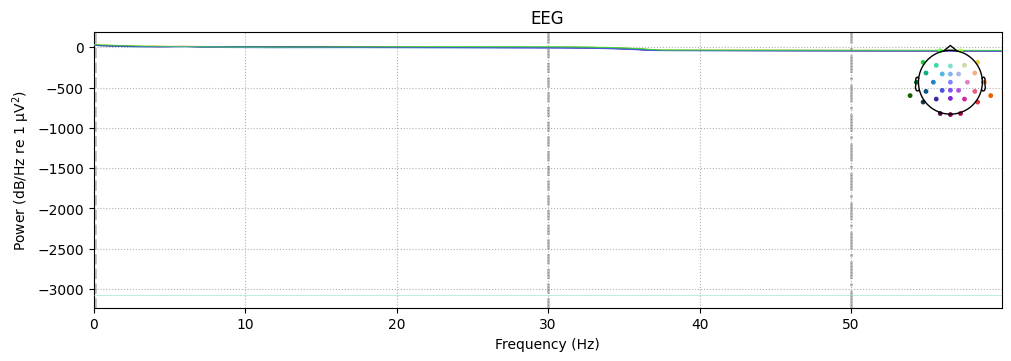

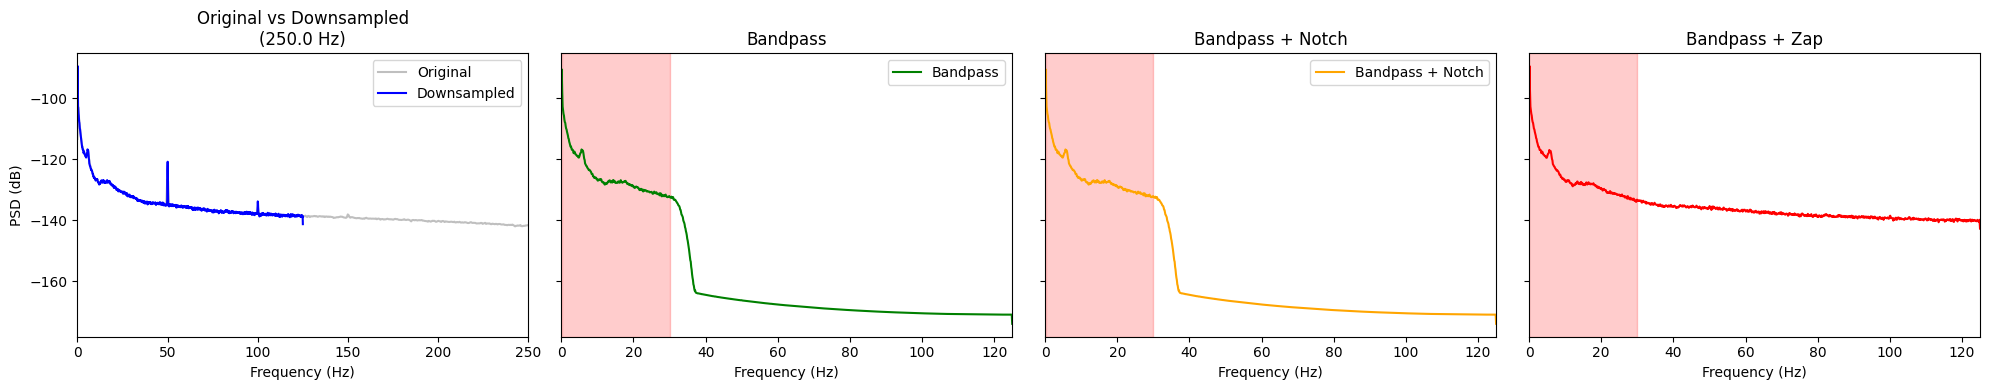

In [25]:
picks = ['FCz']

# Compute PSDs (Spectrum objects)
psd_orig = raw.compute_psd(picks=picks)
psd_down = eeg_down.compute_psd(picks=picks)
psd_band = eeg_band.compute_psd(picks=picks)
psd_band_notch = eeg_band_notch.compute_psd(picks=picks)
psd_band_zap = eeg_band_zap.compute_psd(picks=picks)

# Extract freqs & dB PSDs separately for each
freqs_orig = psd_orig.freqs
p_orig_db = 10 * np.log10(psd_orig.get_data()[0])

freqs_down = psd_down.freqs
p_down_db = 10 * np.log10(psd_down.get_data()[0])

freqs_band = psd_band.freqs
p_band_db = 10 * np.log10(psd_band.get_data()[0])

freqs_band_notch = psd_band_notch.freqs
p_band_notch_db = 10 * np.log10(psd_band_notch.get_data()[0])

freqs_band_zap = psd_band_zap.freqs
p_band_zap_db = 10 * np.log10(psd_band_zap.get_data()[0])


# --- Diagnostic: print sampling rates and Nyquist ---
print("sfreqs:")
print(" raw      :", raw.info['sfreq'], "-> Nyq", raw.info['sfreq'] / 2)
print(" down     :", eeg_down.info['sfreq'], "-> Nyq", eeg_down.info['sfreq'] / 2)
print(" band     :", eeg_band.info['sfreq'], "-> Nyq", eeg_band.info['sfreq'] / 2)
print(" band_notch    :", eeg_band_notch.info['sfreq'], "-> Nyq", eeg_band_notch.info['sfreq'] / 2)
print(" band_zap    :", eeg_band_zap.info['sfreq'], "-> Nyq", eeg_band_zap.info['sfreq'] / 2)

# --- Diagnostic: find power at/near 50 Hz and 200 Hz for each PSD ---
def power_at(freqs, psd_db, target_hz):
    idx = np.argmin(np.abs(freqs - target_hz))
    return freqs[idx], psd_db[idx]

for name, freqs, psd_db in [
    ("orig", freqs_orig, p_orig_db),
    ("down", freqs_down, p_down_db),
    ("band", freqs_band, p_band_db),
    ("band_notch", freqs_band_notch, p_band_notch_db),
    ("band_zap", freqs_band_zap, p_band_zap_db)
]:
    f50, p50 = power_at(freqs, psd_db, 50)
    f200, p200 = power_at(freqs, psd_db, 200)
    print(f"{name:12s}  power @ {f50:.1f}Hz: {p50:.1f} dB,  @ {f200:.1f}Hz: {p200:.1f} dB")

# --- Plot: each PSD with its own x-axis (keeps things aligned) ---
fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharey=True)

axes[0].plot(freqs_orig, p_orig_db, label='Original', color='gray', alpha=0.5)
axes[0].plot(freqs_down, p_down_db, label='Downsampled', color='blue')
axes[0].set_title(f'Original vs Downsampled\n({eeg_down.info["sfreq"]} Hz)')
axes[0].set_xlim(0, 250)
axes[0].set_xlabel('Frequency (Hz)'); axes[0].set_ylabel('PSD (dB)')
axes[0].legend()

axes[1].plot(freqs_band, p_band_db, label='Bandpass', color='green')
axes[1].axvspan(f_low, f_high, color='red', alpha=0.2)
axes[1].set_title('Bandpass')
axes[1].set_xlim(0, min(300, freqs_band.max()))
axes[1].set_xlabel('Frequency (Hz)'); axes[1].legend()

axes[2].plot(freqs_band_notch, p_band_notch_db, label='Bandpass + Notch', color='orange')
axes[2].axvspan(f_low, f_high, color='red', alpha=0.2)
axes[2].set_title('Bandpass + Notch')
axes[2].set_xlim(0, min(300, freqs_band_notch.max()))
axes[2].set_xlabel('Frequency (Hz)'); axes[2].legend()

axes[3].plot(freqs_band_zap, p_band_zap_db, label='Bandpass + Zap', color='red')
axes[3].axvspan(f_low, f_high, color='red', alpha=0.2)
axes[3].set_title('Bandpass + Zap')
axes[3].set_xlim(0, min(300, freqs_band_notch.max()))
axes[3].set_xlabel('Frequency (Hz)'); axes[2].legend()

plt.tight_layout()
plt.show()


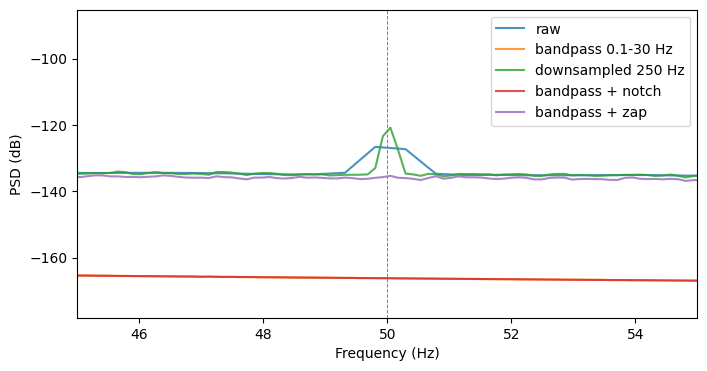

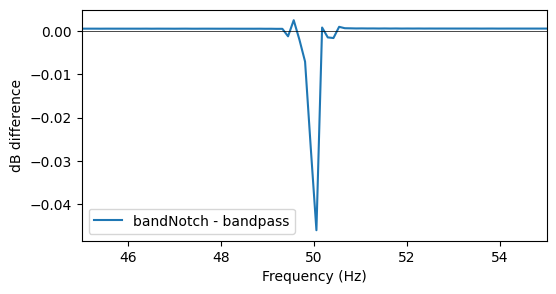

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(freqs_orig, p_orig_db, label='raw', alpha=0.8)
ax.plot(freqs_band, p_band_db,  label='bandpass 0.1-30 Hz', alpha=0.8)
ax.plot(freqs_down, p_down_db,  label='downsampled 250 Hz', alpha=0.8)
ax.plot(freqs_band_notch, p_band_notch_db,  label='bandpass + notch', alpha=0.8)
ax.plot(freqs_band_zap, p_band_zap_db, label='bandpass + zap', alpha=0.8)
ax.set_xlim(45, 55)           # look up to Nyquist of original or 120 Hz
#ax.set_ylim(-166.4,-166.1)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('PSD (dB)')
ax.legend()
ax.axvline(50, color='gray', linestyle='--', linewidth=0.7)
plt.show()

# Zoom near 50 Hz
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.plot(freqs_down, p_band_notch_db - p_band_db, label='bandNotch - bandpass')
ax.set_xlim(45, 55); ax.set_xlabel('Frequency (Hz)'); ax.set_ylabel('dB difference')
ax.axhline(0, color='k', linewidth=0.5)

ax.legend()
plt.show()


*Q: Which one to choose?*

# Re-referencing

In [31]:
has_tp9 = 'TP9' in eeg_band_notch.ch_names
has_tp10 = 'TP10' in eeg_band_notch.ch_names

if has_tp9 and has_tp10:
    print("Re-referencing to average of mastoids (TP9, TP10).")
    eeg_band_notch.set_eeg_reference(ref_channels=['TP9', 'TP10'])
elif has_tp9:
    print("TP10 is missing. Re-referencing to TP9 only.")
    eeg_band_notch.set_eeg_reference(ref_channels=['TP9'])
elif has_tp10:
    print("TP9 is missing. Re-referencing to TP10 only.")
    eeg_band_notch.set_eeg_reference(ref_channels=['TP10'])
else:
    raise RuntimeError("No mastoid channels (TP9 or TP10) found for re-referencing")

Re-referencing to average of mastoids (TP9, TP10).
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


# Cleaning in Time (Trial Rejection)

In [32]:
# split the data into tirals (starts from the onset of fixation thingy)
evts, evts_dict = mne.events_from_annotations(eeg_band_notch)
print(evts_dict)
evts_dict_stim = {k: evts_dict[k] for k in evts_dict.keys() if k in ['Stimulus:S  1', 'Stimulus:S 11', 'Stimulus:S 21', 'Stimulus:S 31']}
trials = mne.Epochs(eeg_band_notch, evts, evts_dict_stim, tmin=0, tmax=3, baseline=None)    #NOTE: from 0s to 3s. maybe extend the window?

Used Annotations descriptions: [np.str_('Comment:Active Shielding: On'), np.str_('Stimulus:S  1'), np.str_('Stimulus:S  2'), np.str_('Stimulus:S  3'), np.str_('Stimulus:S  4'), np.str_('Stimulus:S  5'), np.str_('Stimulus:S  6'), np.str_('Stimulus:S  7'), np.str_('Stimulus:S 11'), np.str_('Stimulus:S 12'), np.str_('Stimulus:S 13'), np.str_('Stimulus:S 14'), np.str_('Stimulus:S 15'), np.str_('Stimulus:S 16'), np.str_('Stimulus:S 17'), np.str_('Stimulus:S 21'), np.str_('Stimulus:S 22'), np.str_('Stimulus:S 23'), np.str_('Stimulus:S 24'), np.str_('Stimulus:S 25'), np.str_('Stimulus:S 26'), np.str_('Stimulus:S 27'), np.str_('Stimulus:S 31'), np.str_('Stimulus:S 32'), np.str_('Stimulus:S 33'), np.str_('Stimulus:S 34'), np.str_('Stimulus:S 35'), np.str_('Stimulus:S 36'), np.str_('Stimulus:S 37')]
{np.str_('Comment:Active Shielding: On'): 10001, np.str_('Stimulus:S  1'): 10002, np.str_('Stimulus:S  2'): 10003, np.str_('Stimulus:S  3'): 10004, np.str_('Stimulus:S  4'): 10005, np.str_('Stimulus:

In [33]:
print(trials.get_data().shape)

Using data from preloaded Raw for 432 events and 751 original time points ...
0 bad epochs dropped
(432, 32, 751)


In [34]:
#NOTE: parameters used are the same as the author, may consider changing them
is_artifacts = np.any(find_artifacts(trials), axis=1).squeeze()
# get the indices of trials of artifacts
is_artifacts_idx = np.where(is_artifacts)[0]
#print(len(is_artifacts_idx))

# drop bad trials
trials.drop(is_artifacts_idx)

Using data from preloaded Raw for 432 events and 751 original time points ...
Dropped 22 epochs: 0, 230, 240, 261, 266, 270, 276, 277, 278, 279, 282, 283, 284, 285, 286, 287, 310, 316, 327, 332, 335, 384


<Epochs | 410 events (all good), 0 – 3 s (baseline off), ~44 KiB, data not loaded,
 np.str_('Stimulus:S  1'): 143
 np.str_('Stimulus:S 11'): 64
 np.str_('Stimulus:S 21'): 65
 np.str_('Stimulus:S 31'): 138>

# ICA analysis

Difference between 3 ICA methods:
- Runica
- Picard
- Fastica

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Using data from preloaded Raw for 410 events and 751 original time points ...
Selecting by non-zero PCA components: 31 components
Using data from preloaded Raw for 410 events and 751 original time points ...
Fitting ICA took 42.5s.


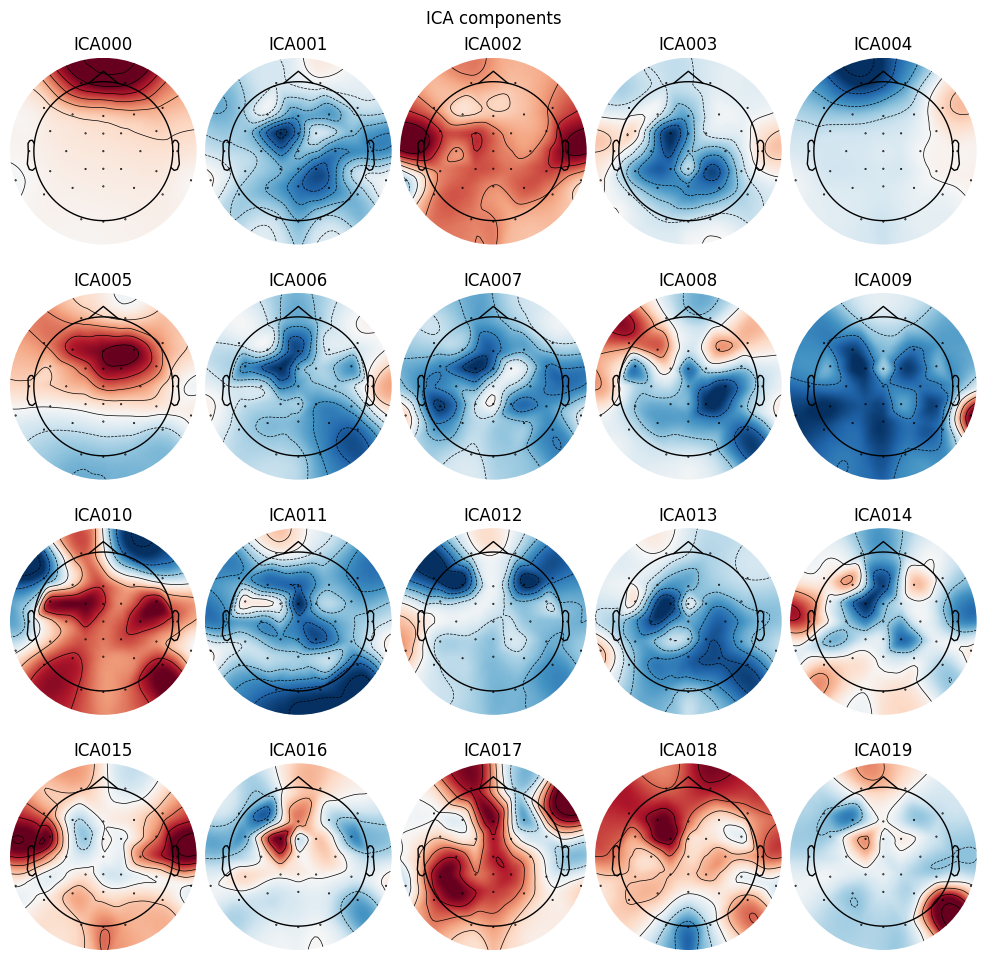

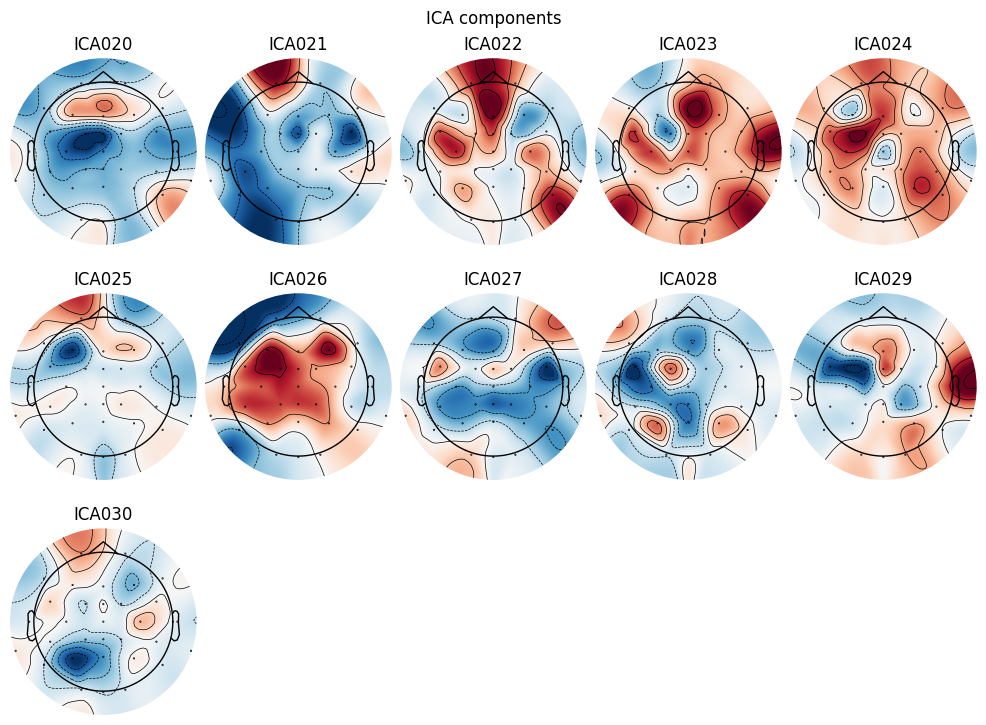

[<MNEFigure size 975x967 with 20 Axes>,
 <MNEFigure size 975x731.5 with 11 Axes>]

In [35]:
ica = mne.preprocessing.ICA(method="picard")
ica.fit(trials,verbose=True)
ica.plot_components()

Using data from preloaded Raw for 410 events and 751 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
410 matching events found
No baseline correction applied
0 projection items activated


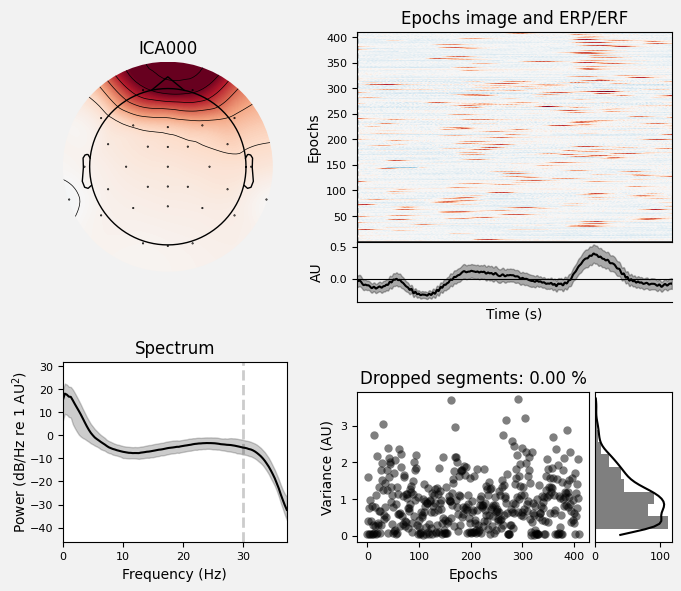

[<Figure size 700x600 with 6 Axes>]

In [36]:
#NOTE: manual inspection. We are using automatic IC rejection?
ica.plot_properties(trials,picks=[0])

# IC Label

In [37]:
from mne_icalabel import label_components

In [38]:
# IC_label expects filtered between 1 and 100 Hz, reference to be common average and ica method to be infomax
# so it's better to combine the result of autolabel and munual check in our case
trials.load_data()
ic_labels = label_components(trials, ica, method='iclabel')

print(ic_labels['labels'])
print(ic_labels['y_pred_proba'])
print("numbe of labels:", len(ic_labels['labels']))

Using data from preloaded Raw for 410 events and 751 original time points ...


C:\Users\Zheng\AppData\Local\Temp\ipykernel_50672\4259037367.py:4: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(trials, ica, method='iclabel')
C:\Users\Zheng\AppData\Local\Temp\ipykernel_50672\4259037367.py:4: RuntimeWarning: The provided ICA instance was fitted with a 'picard' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_params=dict(extended=True))' (scikit-learn) or 'ICA(method='picard', fit_params=dict(ortho=False, extended=True))' (python-picard).
  ic_labels = label_components(trials, ica, method='iclabel')


['eye blink', 'brain', 'other', 'brain', 'eye blink', 'brain', 'other', 'brain', 'brain', 'other', 'other', 'other', 'other', 'brain', 'other', 'other', 'other', 'other', 'other', 'other', 'brain', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other', 'other']
[0.9669115  0.5146687  0.64801127 0.7803893  0.70018446 0.9970992
 0.8633482  0.5071229  0.47548032 0.82112837 0.43434432 0.3898785
 0.52029943 0.9551363  0.9764833  0.84001005 0.46039206 0.7319714
 0.84596825 0.50314677 0.98679364 0.74997336 0.9758415  0.9463806
 0.9330627  0.7389614  0.80199605 0.9399909  0.61931175 0.92935514
 0.52887005]
numbe of labels: 31


C:\Users\Zheng\AppData\Local\Temp\ipykernel_50672\105353859.py:21: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.6, wspace=0.1, bottom=0.15)


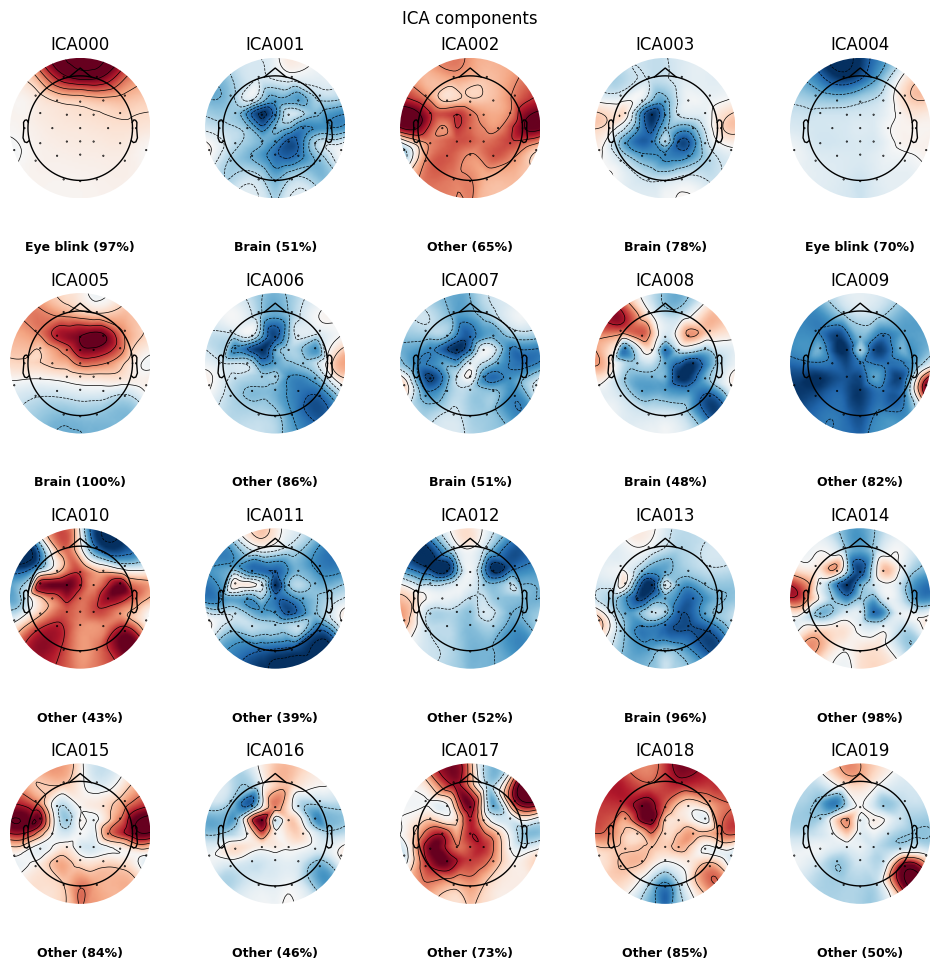

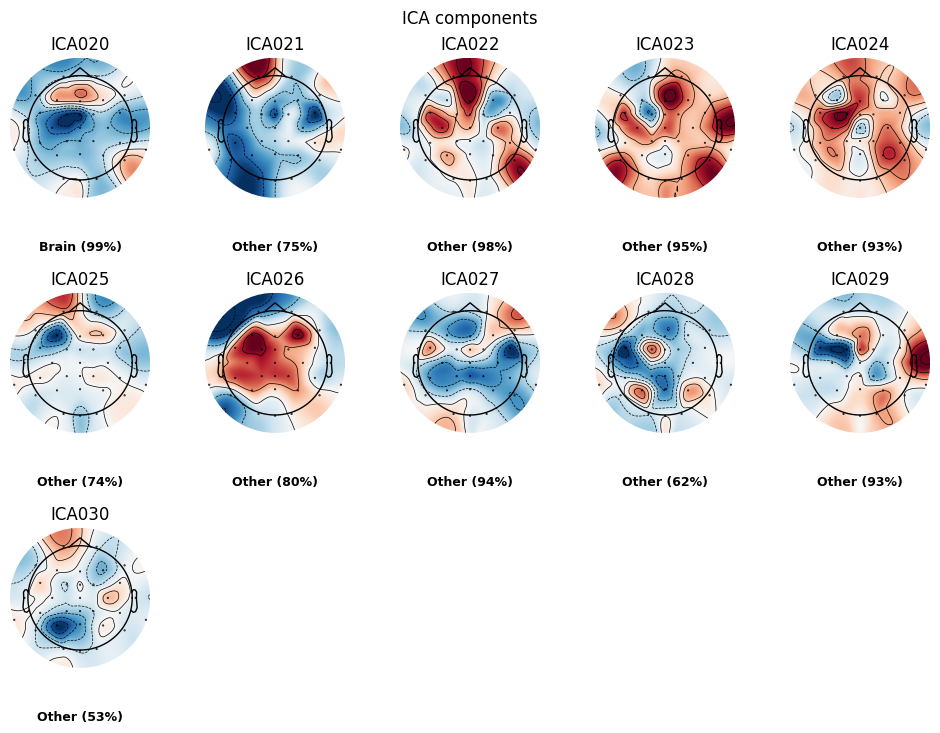

In [39]:
# visualization of ic label with corresponding scalp picture
labels = ic_labels['labels'] 
probs = ic_labels['y_pred_proba'] 

# plot out scalp picture and the auto ic label
titles = []
for i, label in enumerate(labels):
    probability = np.max(probs[i])
    
    title = f"{label.capitalize()} ({probability:.0%})"
    titles.append(title)


figs = ica.plot_components(inst=trials, show=False)

if not isinstance(figs, list):
    figs = [figs]

comp_idx = 0
for fig in figs:
    fig.subplots_adjust(hspace=0.6, wspace=0.1, bottom=0.15)
    for ax in fig.axes:
        if comp_idx >= len(titles):
            break
            
        ax.text(0.5, -0.3, titles[comp_idx], 
                transform=ax.transAxes, 
                ha='center', va='top', fontsize=9, color='black', fontweight='bold')
        
        comp_idx += 1

plt.show()

In [40]:

# authors only remove eye components and leaves other intact
exclude_idx = []
for i, label in enumerate(labels):
    if label == 'eye' and probs[i] > 0.8:
        exclude_idx.append(i)

ica.exclude = exclude_idx
ica.apply(eeg_band_notch)

Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 0 ICA components
    Projecting back using 32 PCA components


<RawBrainVision | sub-27_task-casinos_eeg.eeg, 32 x 790405 (3161.6 s), ~193.0 MiB, data loaded>

# Baseline correction

In [41]:
# intepolation
common_montage_path = "C:\\Users\\Zheng\\Desktop\\fourth semester\\EEG\\common.locs"
montage_common = mne.channels.read_custom_montage(common_montage_path)
eeg_band_notch.set_montage(montage_common, on_missing='ignore') 

if len(eeg_band_notch.info['bads']) > 0:
    print(f"Interpolating bad channels: {eeg_band_notch.info['bads']}")
    eeg_band_notch.interpolate_bads(reset_bads=True)
else:
    print("No bad channels marked for interpolation")

No bad channels marked for interpolation


In [43]:
# for participants of site 2, need to remove ['O1','O2','CPz'] channels to make sure it has same num of channels as site 1
channels_to_remove = ['O1','O2','CPz']
eeg_band_notch.drop_channels(channels_to_remove, on_missing='ignore')

# left 29 channels which is different from what they have stated in make_erp (they set 30 channels)

<RawBrainVision | sub-27_task-casinos_eeg.eeg, 29 x 790405 (3161.6 s), ~174.9 MiB, data loaded>

In [44]:
mne.events_from_annotations(eeg_band_zap)

Used Annotations descriptions: [np.str_('Comment'), np.str_('New Segment'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  3'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S 11'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 13'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15'), np.str_('Stimulus/S 16'), np.str_('Stimulus/S 17'), np.str_('Stimulus/S 21'), np.str_('Stimulus/S 22'), np.str_('Stimulus/S 23'), np.str_('Stimulus/S 24'), np.str_('Stimulus/S 25'), np.str_('Stimulus/S 26'), np.str_('Stimulus/S 27'), np.str_('Stimulus/S 31'), np.str_('Stimulus/S 32'), np.str_('Stimulus/S 33'), np.str_('Stimulus/S 34'), np.str_('Stimulus/S 35'), np.str_('Stimulus/S 36'), np.str_('Stimulus/S 37')]


(array([[     0,      0,  10002],
        [     0,      0,  10001],
        [ 72691,      0,      1],
        ...,
        [784566,      0,     33],
        [784597,      0,     34],
        [785202,      0,     36]], shape=(2152, 3)),
 {np.str_('Comment'): 10001,
  np.str_('New Segment'): 10002,
  np.str_('Stimulus/S  1'): 1,
  np.str_('Stimulus/S  2'): 2,
  np.str_('Stimulus/S  3'): 3,
  np.str_('Stimulus/S  4'): 4,
  np.str_('Stimulus/S  5'): 5,
  np.str_('Stimulus/S  6'): 6,
  np.str_('Stimulus/S  7'): 7,
  np.str_('Stimulus/S 11'): 11,
  np.str_('Stimulus/S 12'): 12,
  np.str_('Stimulus/S 13'): 13,
  np.str_('Stimulus/S 14'): 14,
  np.str_('Stimulus/S 15'): 15,
  np.str_('Stimulus/S 16'): 16,
  np.str_('Stimulus/S 17'): 17,
  np.str_('Stimulus/S 21'): 21,
  np.str_('Stimulus/S 22'): 22,
  np.str_('Stimulus/S 23'): 23,
  np.str_('Stimulus/S 24'): 24,
  np.str_('Stimulus/S 25'): 25,
  np.str_('Stimulus/S 26'): 26,
  np.str_('Stimulus/S 27'): 27,
  np.str_('Stimulus/S 31'): 31,
  np.

In [45]:
print("Current channels:", eeg_band_zap.ch_names)

Current channels: ['Fp1', 'F3', 'F7', 'FC5', 'FC1', 'FCz', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'Oz', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'Fz']


In [47]:
def exclude_early_trials(data, num_to_exclude=10):
    """
    Exclude first few trials (default: 10)
        'S  1' = start of low-value task fixation (all low cue)
        'S 11' = start of mixed task fixation(low cue)
        'S 21' = start of mixed task fixation(high cue)
        'S 31' = start of high-value task fixation(all high cue)
    """
    events, event_dict = mne.events_from_annotations(data)
    
    # trial counts per task type
    trial_count = {'S 1': 0, 'S 11_S 21': 0, 'S 31': 0}

    task_start_ids = {}
    
    # Find the event ID for task starters so that we could know when one trial stops
    for event_name, event_id in event_dict.items():
        if 'Stimulus:S  1' == event_name:
            task_start_ids['S 1'] = [event_id]
        elif 'Stimulus:S 11' == event_name or 'Stimulus:S 21'== event_name:
            if 'S 11_S 21' not in task_start_ids: 
                task_start_ids['S 11_S 21'] = []
            task_start_ids['S 11_S 21'].append(event_id)
        elif 'Stimulus:S 31' == event_name:
            task_start_ids['S 31'] = [event_id]
    print(task_start_ids)

    # flatten all start ids
    all_task_starts = []
    for ids in task_start_ids.values():
        all_task_starts.extend(ids)
    print(all_task_starts)

    events_to_exclude = []
    i = 0
    while i < len(events):
        event_id = events[i, 2] # ith event's eventid (2 means event id)
        
        # Determine if this event marks the start of a trial
        current_task_type = None
        if 'S 1' in task_start_ids and event_id in task_start_ids['S 1']:
            current_task_type = 'S 1'
        elif 'S 11_S 21' in task_start_ids and event_id in task_start_ids['S 11_S 21']:
            current_task_type = 'S 11_S 21'
        elif 'S 31' in task_start_ids and event_id in task_start_ids['S 31']:
            current_task_type = 'S 31'

        # If it is a trial start
        if current_task_type is not None:
            # Check if the trial should be excluded
            if trial_count[current_task_type] < num_to_exclude:
                events_to_exclude.append(i)
                
                # Mark subsequent events until the next trial starts
                j = 1
                while (i + j) < len(events):
                    next_id = events[i + j, 2]
                    if next_id in all_task_starts:
                        break 
                    events_to_exclude.append(i + j)
                    j += 1
            
            trial_count[current_task_type] += 1
        
        i += 1
    print(trial_count)

    # Remove excluded events
    if events_to_exclude:
        # Create mask: True = keep, False = exclude
        keep_mask = np.ones(len(events), dtype=bool)
        keep_mask[events_to_exclude] = False

        # Keep only non-excluded events
        events_filtered = events[keep_mask]

        data_clean = data.copy()
        
        # Add back the filtered events
        new_annot = mne.annotations_from_events(
            events_filtered,
            data_clean.info['sfreq'],
            event_desc={v: k for k, v in event_dict.items()}
        )
        data_clean.set_annotations(new_annot)
        
        print(f"Excluded {len(events_to_exclude)} events (first {num_to_exclude} trials of each block).")
        return data_clean
    else:
        print("No trials excluded.")
        return data.copy()



In [48]:
eeg_final = exclude_early_trials(eeg_band_notch, num_to_exclude=10)

Used Annotations descriptions: [np.str_('Comment:Active Shielding: On'), np.str_('Stimulus:S  1'), np.str_('Stimulus:S  2'), np.str_('Stimulus:S  3'), np.str_('Stimulus:S  4'), np.str_('Stimulus:S  5'), np.str_('Stimulus:S  6'), np.str_('Stimulus:S  7'), np.str_('Stimulus:S 11'), np.str_('Stimulus:S 12'), np.str_('Stimulus:S 13'), np.str_('Stimulus:S 14'), np.str_('Stimulus:S 15'), np.str_('Stimulus:S 16'), np.str_('Stimulus:S 17'), np.str_('Stimulus:S 21'), np.str_('Stimulus:S 22'), np.str_('Stimulus:S 23'), np.str_('Stimulus:S 24'), np.str_('Stimulus:S 25'), np.str_('Stimulus:S 26'), np.str_('Stimulus:S 27'), np.str_('Stimulus:S 31'), np.str_('Stimulus:S 32'), np.str_('Stimulus:S 33'), np.str_('Stimulus:S 34'), np.str_('Stimulus:S 35'), np.str_('Stimulus:S 36'), np.str_('Stimulus:S 37')]
{'S 1': [10002], 'S 11_S 21': [10009, 10016], 'S 31': [10023]}
[10002, 10009, 10016, 10023]
{'S 1': 144, 'S 11_S 21': 144, 'S 31': 144}
Excluded 148 events (first 10 trials of each block).


In [49]:
events, event_id = mne.events_from_annotations(eeg_final)
print(event_id)

Used Annotations descriptions: [np.str_('Comment:Active Shielding: On'), np.str_('Stimulus:S  1'), np.str_('Stimulus:S  2'), np.str_('Stimulus:S  3'), np.str_('Stimulus:S  4'), np.str_('Stimulus:S  5'), np.str_('Stimulus:S  6'), np.str_('Stimulus:S  7'), np.str_('Stimulus:S 11'), np.str_('Stimulus:S 12'), np.str_('Stimulus:S 13'), np.str_('Stimulus:S 14'), np.str_('Stimulus:S 15'), np.str_('Stimulus:S 16'), np.str_('Stimulus:S 17'), np.str_('Stimulus:S 21'), np.str_('Stimulus:S 22'), np.str_('Stimulus:S 23'), np.str_('Stimulus:S 24'), np.str_('Stimulus:S 25'), np.str_('Stimulus:S 26'), np.str_('Stimulus:S 27'), np.str_('Stimulus:S 31'), np.str_('Stimulus:S 32'), np.str_('Stimulus:S 33'), np.str_('Stimulus:S 34'), np.str_('Stimulus:S 35'), np.str_('Stimulus:S 36'), np.str_('Stimulus:S 37')]
{np.str_('Comment:Active Shielding: On'): 10001, np.str_('Stimulus:S  1'): 10002, np.str_('Stimulus:S  2'): 10003, np.str_('Stimulus:S  3'): 10004, np.str_('Stimulus:S  4'): 10005, np.str_('Stimulus:

In [50]:
CONDITIONS_DICT = {
    # Cue-Locked Conditions
    'lowP-uniform':  ['Stimulus:S  2'],
    'lowP-mixed':    ['Stimulus:S 12'],
    'highP-mixed':   ['Stimulus:S 22'],
    'highP-uniform': ['Stimulus:S 32'],

    # Feedback-Locked Conditions
    'Low-Low Win':   ['Stimulus:S  6'], 
    'Low-Low Loss':  ['Stimulus:S  7'], 
    'Mid-Low Win':   ['Stimulus:S 16'], 
    'Mid-Low Loss':  ['Stimulus:S 17'], 
    'Mid-High Win':  ['Stimulus:S 26'], 
    'Mid-High Loss': ['Stimulus:S 27'],
    'High-High Win': ['Stimulus:S 36'], 
    'High-High Loss':['Stimulus:S 37'],

    # Win-Loss Conditions
    'All Win':  ['Stimulus:S  6', 'Stimulus:S 16', 'Stimulus:S 26', 'Stimulus:S 36'],
    'All Loss': ['Stimulus:S  7', 'Stimulus:S 17', 'Stimulus:S 27', 'Stimulus:S 37']
}

all_markers = []
for markers in CONDITIONS_DICT.values():
    all_markers.extend(markers)

# Create the filtered event dictionary
# We look for EXACT matches now, since we know the exact strings
evts_dict_stim = {k: event_id[k] for k in event_id.keys() if k in all_markers}

In [51]:
print(evts_dict_stim)

{np.str_('Stimulus:S  2'): 10003, np.str_('Stimulus:S  6'): 10007, np.str_('Stimulus:S  7'): 10008, np.str_('Stimulus:S 12'): 10010, np.str_('Stimulus:S 16'): 10014, np.str_('Stimulus:S 17'): 10015, np.str_('Stimulus:S 22'): 10017, np.str_('Stimulus:S 26'): 10021, np.str_('Stimulus:S 27'): 10022, np.str_('Stimulus:S 32'): 10024, np.str_('Stimulus:S 36'): 10028, np.str_('Stimulus:S 37'): 10029}


In [52]:
# build new epochs with parameters following authors
epochs_all = mne.Epochs(
    eeg_final, 
    events, 
    evts_dict_stim, 
    tmin=-0.2, 
    tmax=0.6, 
    baseline=(-0.2, 0),
    preload=True
)

is_artifacts = np.any(find_artifacts(epochs_all, maxMin=150e-6, level=150e-6, step=40e-6,lowest=0.1e-6), axis=1).squeeze()

is_artifacts_idx = np.where(is_artifacts)[0]

epochs_all.drop(is_artifacts_idx)


Not setting metadata
800 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 800 events and 201 original time points ...
0 bad epochs dropped
Dropped 325 epochs: 0, 1, 3, 5, 10, 12, 13, 16, 17, 20, 22, 24, 27, 29, 32, 35, 36, 40, 44, 46, 47, 49, 51, 53, 55, 60, 64, 68, 70, 75, 80, 81, 83, 87, 90, 92, 93, 96, 102, 104, 106, 112, 114, 116, 121, 124, 127, 129, 130, 132, 136, 137, 138, 140, 141, 143, 146, 148, 149, 154, 156, 157, 158, 159, 160, 163, 165, 166, 167, 171, 173, 175, 178, 181, 182, 186, 189, 196, 205, 208, 210, 214, 216, 218, 220, 226, 228, 230, 234, 240, 246, 254, 256, 257, 260, 261, 262, 271, 274, 277, 278, 280, 281, 285, 290, 291, 293, 294, 296, 299, 303, 304, 305, 306, 309, 311, 314, 317, 320, 322, 325, 329, 330, 331, 332, 333, 336, 337, 339, 340, 343, 348, 352, 353, 358, 361, 366, 367, 369, 370, 371, 373, 378, 380, 383, 386, 388, 390, 393, 395, 396, 397, 398, 400, 401, 402, 403, 408, 412, 414, 421, 

<Epochs | 475 events (all good), -0.2 – 0.6 s (baseline -0.2 – 0 s), ~21.2 MiB, data loaded,
 np.str_('Stimulus:S  2'): 85
 np.str_('Stimulus:S  6'): 38
 np.str_('Stimulus:S  7'): 46
 np.str_('Stimulus:S 12'): 48
 np.str_('Stimulus:S 16'): 18
 np.str_('Stimulus:S 17'): 15
 np.str_('Stimulus:S 22'): 33
 np.str_('Stimulus:S 26'): 21
 np.str_('Stimulus:S 27'): 10
 np.str_('Stimulus:S 32'): 91
 and 2 more events ...>

add bad channel detection=

# Make ERP

In [53]:
# apply trimmed mean
from scipy.stats import trim_mean

def get_trimmed_mean(epochs, proportiontocut=0.05):
    data = epochs.get_data()
    trimmed_erp_data = np.apply_along_axis(
        trim_mean,
        axis=0, # along the trial axis
        arr=data,
        proportiontocut=proportiontocut
    ) # (n_channels, n_times)
    # Create the final Evoked object
    trimmed_evoked = mne.EvokedArray(
        trimmed_erp_data, 
        epochs.info, 
        tmin=epochs.times[0]
    )
    return trimmed_evoked




In [54]:
all_evokeds = {}
for name, markers in CONDITIONS_DICT.items():
    # Only try to index if the marker exists in the filtered events
    valid_markers_for_cond = [m for m in markers if m in epochs_all.event_id]
    
    if valid_markers_for_cond:
        epochs_cond = epochs_all[valid_markers_for_cond] 
        if len(epochs_cond) > 0:
            erp_cond = get_trimmed_mean(epochs_cond, proportiontocut=0.05)
            all_evokeds[name] = erp_cond
        else:
            print(f"Warning: No epochs found for condition {name}")
    else:
        print(f"Warning: Condition {name} markers not found in epochs.")


In [55]:
# using mean amplitude to measure erp amplitude
def calculate_mean_amplitude(evoked, channel_name, tmin, tmax):
    """Calculates the mean amplitude for a channel within a time window."""
    
    # Select the specific channel
    data = evoked.get_data(picks=channel_name)[0] 
    
    # Get the time indices corresponding to the window (tmin, tmax)
    i_start, i_end = evoked.time_as_index([tmin, tmax])
    
    # calculate the mean across time (axis 1)
    mean_val = np.mean(data[i_start:i_end + 1])
    
    return mean_val * 1e6 # Convert Volts to microvolts (µV)

# using peak-to-peak
def calculate_peak_to_peak(evoked, channel_name, tmin, tmax):
    """
    Calculates peak-to-peak within a single time window.
    Finds the minimum (negative peak) and maximum (positive peak) in the same window.
    """
    data = evoked.get_data(picks=channel_name)[0]
    times = evoked.times
    
    # Single search window for both peaks
    i_start, i_end = evoked.time_as_index([tmin, tmax])
    
    # Find minimum (most negative) and maximum (most positive) in this window
    n_idx = i_start + np.argmin(data[i_start:i_end + 1])
    p_idx = i_start + np.argmax(data[i_start:i_end + 1])
    
    n_amplitude = data[n_idx]
    p_amplitude = data[p_idx]
    n_time = times[n_idx]
    p_time = times[p_idx]
    
    # Peak-to-peak difference
    peak_to_peak = (p_amplitude - n_amplitude) * 1e6
    
    return peak_to_peak, n_time * 1000, p_time* 1000, n_amplitude, p_amplitude

In [56]:
win = [k for k in CONDITIONS_DICT.keys() if 'Win' in k]
loss = [k for k in CONDITIONS_DICT.keys() if 'Loss' in k]
valid_win_names = [name for name in win if name in all_evokeds]
valid_loss_names = [name for name in loss if name in all_evokeds]

if valid_win_names and valid_loss_names:
    # calculate average amplitude for win and lose cases
    win_evokeds_list = [all_evokeds[name] for name in valid_win_names]
    loss_evokeds_list = [all_evokeds[name] for name in valid_loss_names]
    
    erp_grand_win = mne.combine_evoked(win_evokeds_list, weights='equal')
    erp_grand_loss = mne.combine_evoked(loss_evokeds_list, weights='equal')
    rewp_diff = mne.combine_evoked([erp_grand_win, erp_grand_loss], weights=[1, -1])

    # Parameters
    channel = 'FCz'
    mean_window = [0.240, 0.340] # as set by authors

    # Metrics
    rewp_mean_amplitude = calculate_mean_amplitude(rewp_diff, channel, mean_window[0], mean_window[1])
    p2p_amp, n_time, p_time, n_val, p_val = calculate_peak_to_peak(rewp_diff, channel, mean_window[0], mean_window[1])

 
    print(f"RewP Mean Amplitude: {rewp_mean_amplitude:.2f} µV")
    print(f"RewP Peak-to-Peak: {p2p_amp:.2f} µV")




RewP Mean Amplitude: 0.49 µV
RewP Peak-to-Peak: 2.88 µV


Low-Low Win: P2P = 7.54 µV (N: 248000ms, P: 324000ms)
Low-Low Loss: P2P = 4.83 µV (N: 292000ms, P: 340000ms)
Mid-Low Win: P2P = 6.77 µV (N: 288000ms, P: 340000ms)
Mid-Low Loss: P2P = 9.44 µV (N: 276000ms, P: 328000ms)
Mid-High Win: P2P = 9.31 µV (N: 252000ms, P: 328000ms)
Mid-High Loss: P2P = 13.59 µV (N: 244000ms, P: 332000ms)
High-High Win: P2P = 5.80 µV (N: 248000ms, P: 328000ms)
High-High Loss: P2P = 9.38 µV (N: 244000ms, P: 304000ms)


C:\Users\Zheng\AppData\Local\Temp\ipykernel_50672\1659520271.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


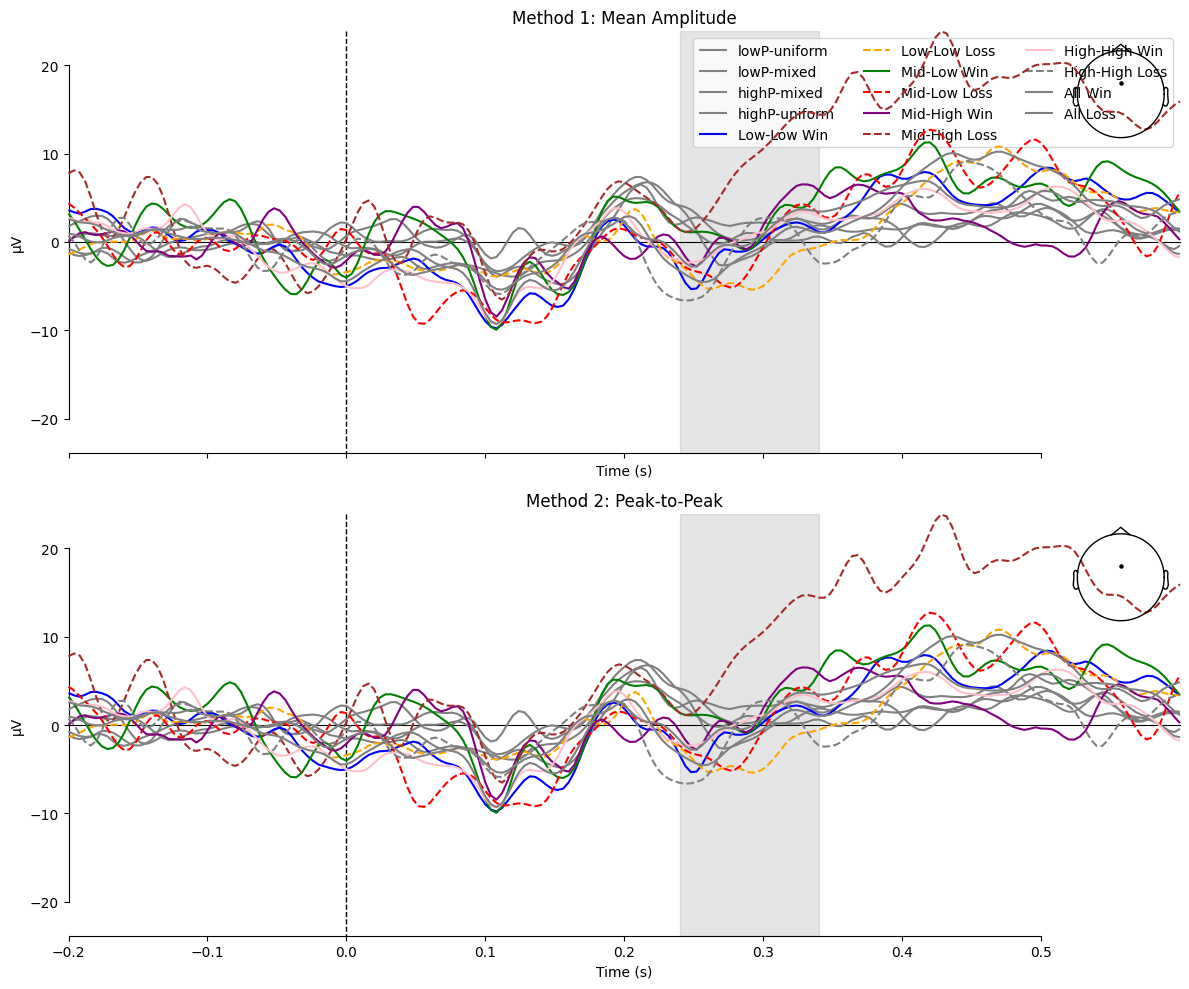

In [57]:
channel = 'FCz'
twindow = [0.240, 0.340]

# Define styles for the plot
colors = {
    'Low-Low Win': 'blue', 'Low-Low Loss': 'orange',
    'Mid-Low Win': 'green', 'Mid-Low Loss': 'red',
    'Mid-High Win': 'purple', 'Mid-High Loss': 'brown',
    'High-High Win': 'pink', 'High-High Loss': 'gray'
}
linestyles = {
    'Low-Low Win': '-', 'Low-Low Loss': '--',
    'Mid-Low Win': '-', 'Mid-Low Loss': '--',
    'Mid-High Win': '-', 'Mid-High Loss': '--',
    'High-High Win': '-', 'High-High Loss': '--'
}

# Create figure
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True, sharey=True)

# Subplot 1: Mean Amplitude
mne.viz.plot_compare_evokeds(
    all_evokeds,
    picks=[channel],
    colors=colors,
    linestyles=linestyles,
    axes=axes[0],
    title=f"Method 1: Mean Amplitude",
    legend='upper right',
    ci=True,
    show=False
)
# Add shading for Mean Amplitude window
axes[0].axvspan(mean_window[0], mean_window[1], color='gray', alpha=0.2, label='Mean Window')

# Subplot 2: Peak-to-Peak
mne.viz.plot_compare_evokeds(
    all_evokeds,
    picks=[channel],
    colors=colors,
    linestyles=linestyles,
    axes=axes[1],
    title=f"Method 2: Peak-to-Peak",
    legend=False, # Legend is same as top
    ci=True,
    show=False
)

# Iterate through each condition to calculate and plot its specific P2P markers
for name, evoked in all_evokeds.items():
    if name in colors: # Only plot if we have a color for it
        # Calculate P2P for this specific condition
        p2p_amp, n_time, p_time, n_val, p_val = calculate_peak_to_peak(
            evoked, channel, twindow[0], twindow[1]
        )
        
        # Plot the markers on the second subplot
        # We use the condition's specific color for the markers
        color = colors[name]
        
        # Negative Peak Marker
        axes[1].plot(n_time, n_val, marker='v', color=color, markersize=8, alpha=0.7)
        # Positive Peak Marker
        axes[1].plot(p_time, p_val, marker='^', color=color, markersize=8, alpha=0.7)
        # Connecting line
        axes[1].plot([n_time, p_time], [n_val, p_val], color=color, linestyle=':', alpha=0.5)


        print(f"{name}: P2P = {p2p_amp:.2f} µV (N: {n_time*1000:.0f}ms, P: {p_time*1000:.0f}ms)")
axes[1].axvspan(mean_window[0], mean_window[1], color='gray', alpha=0.2, label='Mean Window')
axes[1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

Calculated difference for: Low-Low
Calculated difference for: Mid-Low
Calculated difference for: Mid-High
Calculated difference for: High-High


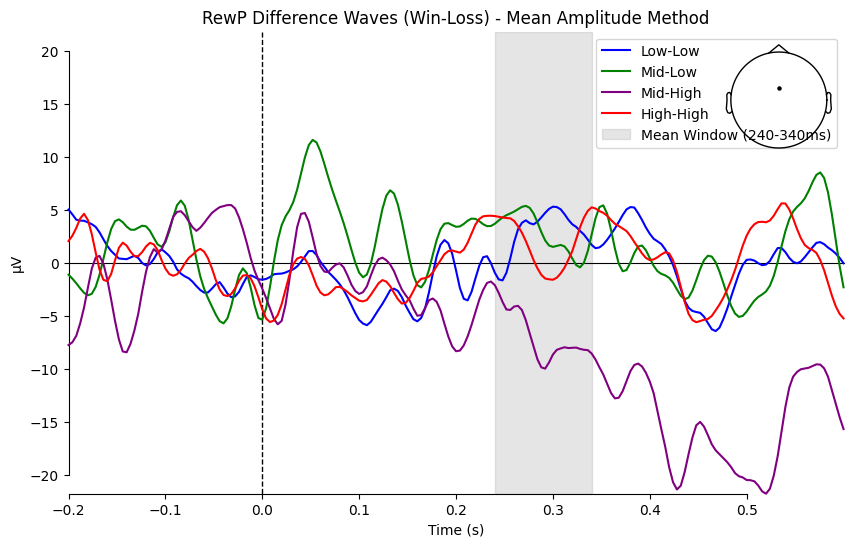


Generating Figure 2: Peak-to-Peak Measurement...

--- Calculating and Plotting P2P Markers ---
Low-Low Diff: P2P = 6.95 µV (N: 248000ms, P: 300000ms)
Mid-Low Diff: P2P = 5.80 µV (N: 328000ms, P: 272000ms)
Mid-High Diff: P2P = 7.89 µV (N: 292000ms, P: 240000ms)
High-High Diff: P2P = 6.83 µV (N: 300000ms, P: 340000ms)


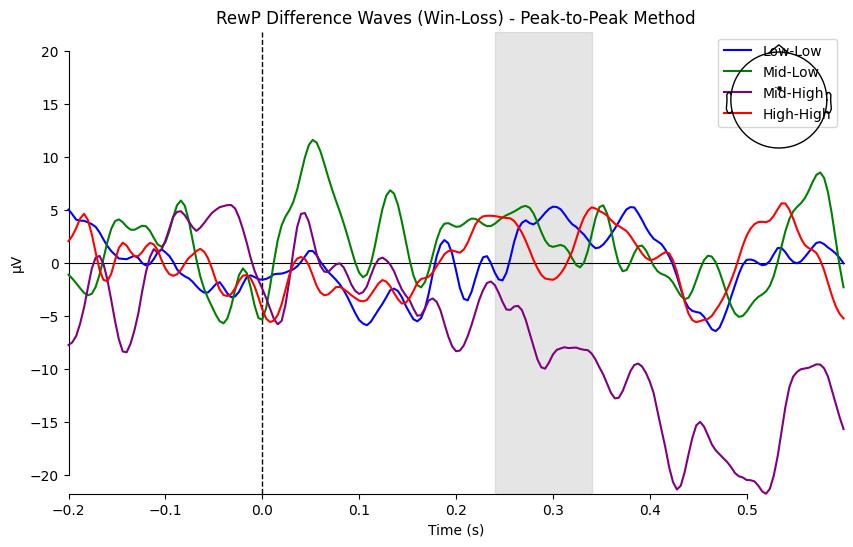

In [58]:
diff_evokeds = {}

cases = [
    ('Low-Low', 'Low-Low Win', 'Low-Low Loss'),
    ('Mid-Low', 'Mid-Low Win', 'Mid-Low Loss'),
    ('Mid-High', 'Mid-High Win', 'Mid-High Loss'),
    ('High-High', 'High-High Win', 'High-High Loss')
]

for case_name, win_cond, loss_cond in cases:
    if win_cond in all_evokeds and loss_cond in all_evokeds:
        # Calculate Difference: Win - Loss
        diff = mne.combine_evoked(
            [all_evokeds[win_cond], all_evokeds[loss_cond]],
            weights=[1, -1]
        )
        diff.comment = case_name # Set name for plotting
        diff_evokeds[case_name] = diff
        print(f"Calculated difference for: {case_name}")
    else:
        print(f"Warning: Missing conditions for {case_name}. Cannot calculate difference.")

colors_diff = {
    'Low-Low': 'blue',  
    'Mid-Low': 'green',   
    'Mid-High': 'purple',  
    'High-High': 'red'  
}

# FIGURE 1: Mean Amplitude Visualization
fig1, ax1 = plt.subplots(figsize=(10, 6))

mne.viz.plot_compare_evokeds(
    diff_evokeds,
    picks=[channel],
    colors=colors_diff,
    axes=ax1,
    title=f"RewP Difference Waves (Win-Loss) - Mean Amplitude Method",
    legend='upper right',
    show=False
)

ax1.axvspan(mean_window[0], mean_window[1], color='gray', alpha=0.2, label=f'Mean Window ({mean_window[0]*1000:.0f}-{mean_window[1]*1000:.0f}ms)')
ax1.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.show()


# FIGURE 2: Peak-to-Peak Amplitude Visualization
print("\nGenerating Figure 2: Peak-to-Peak Measurement...")
fig2, ax2 = plt.subplots(figsize=(10, 6))

mne.viz.plot_compare_evokeds(
    diff_evokeds,
    picks=[channel],
    colors=colors_diff,
    axes=ax2,
    title=f"RewP Difference Waves (Win-Loss) - Peak-to-Peak Method",
    legend='upper right', 
    show=False
)

print("\n--- Calculating and Plotting P2P Markers ---")
# Create dummy handles for the legend to ensure clean labels

for name, evoked in diff_evokeds.items():
    if name in colors_diff:
        # Calculate P2P for this difference wave
        p2p_amp, n_time, p_time, n_val, p_val = calculate_peak_to_peak(
            evoked, channel, twindow[0], twindow[1]
        )
        
        color = colors_diff[name]
        # Plot markers and connecting line
        ax2.plot(n_time, n_val, marker='v', color=color, markersize=8, alpha=0.7)
        ax2.plot(p_time, p_val, marker='^', color=color, markersize=8, alpha=0.7)
        ax2.plot([n_time, p_time], [n_val, p_val], color=color, linestyle=':', alpha=0.5)

        print(f"{name} Diff: P2P = {p2p_amp:.2f} µV (N: {n_time*1000:.0f}ms, P: {p_time*1000:.0f}ms)")
ax2.axvspan(mean_window[0], mean_window[1], color='gray', alpha=0.2, label=f'Mean Window ({mean_window[0]*1000:.0f}-{mean_window[1]*1000:.0f}ms)')
plt.grid(True, alpha=0.3)
plt.show()
